<a href="https://colab.research.google.com/github/nidjosep/student-feedback-analysis/blob/master/models/model-source/Model_3_Actionable_Insights_from_Student_Feedback_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aspect Based Sentiment Analysis for Student Feedbacks**

# 1. Setting Up the Environment

In [70]:
!pip install --upgrade transformers sentencepiece tensorflow

In [71]:
# download resources
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Aspect Identification in Test Data

In [72]:
import torch.nn.functional as F
from collections import Counter
import pandas as pd
from google.colab import drive

def extract_aspects_from_sentence(sentence):
    txt = sentence.lower()
    sentList = nltk.sent_tokenize(txt)

    aspects = set()
    noun_pairs = set()
    redundant_nouns = set()

    for line in sentList:
        txt_list = nltk.word_tokenize(line)
        taggedList = nltk.pos_tag(txt_list)

        for i in range(len(taggedList) - 1):
            if taggedList[i][1] == "NN" and taggedList[i + 1][1] == "NN":
                aspect = taggedList[i][0] + ' ' + taggedList[i + 1][0]
                noun_pairs.add(aspect)
                redundant_nouns.add(taggedList[i][0])
                redundant_nouns.add(taggedList[i + 1][0])

        # Add individual nouns if they are not part of noun pairs
        for i in range(len(taggedList)):
            if taggedList[i][1] == "NN" and taggedList[i][0] not in stop_words:
                if taggedList[i][0] not in noun_pairs and taggedList[i][0] not in redundant_nouns and taggedList[i][0].isalpha() :
                    aspects.add(taggedList[i][0])

    # Add noun pairs to aspects
    aspects.update(noun_pairs)

    return list(aspects)

# function to identify aspects from a list of feedbacks
def identify_aspects(feedbacks):
    aspect_counter = Counter()

    # Extract aspects from each feedback and count them
    for feedback in feedbacks:
        extracted_aspects = extract_aspects_from_sentence(feedback)
        aspect_counter.update(extracted_aspects)

    # Find the top 2 aspects
    top_aspects = aspect_counter.most_common(2)

    # Convert top aspects to uppercase
    return [aspect.upper() for aspect, count in top_aspects]

# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/MCSC/TME_6015/Project/test_data_set_all_model.csv')

feedbacks = df['Feedback'].to_list()

top_aspects = identify_aspects(feedbacks);
print(f"Top 3 aspects identified are : {top_aspects}\n")

Mounted at /content/drive
Top 3 aspects identified are : ['LAB', 'PROFESSOR']



# Loading the Aspect-Based Sentiment Analysis Model

In [73]:
# Load Aspect-Based Sentiment Analysis model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

absa_model

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

# Evaluation of ABSA Model on Test Dataset

Mounted at /content/drive


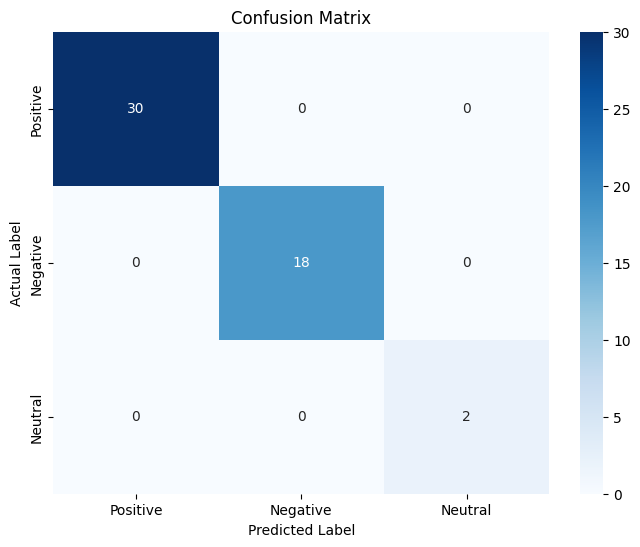


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [86]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

def predict_sentiment(text, aspects):

    aspect_sentiments = {}

    for aspect in aspects:
        # Load Aspect-Based Sentiment Analysis model
        inputs = absa_tokenizer(f"[CLS] {text} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]

        # Find the sentiment with the highest score
        max_index = probs.argmax()
        sentiment = ["Negative", "Neutral", "Positive"][max_index]
        score = probs[max_index]

        # Store the result
        aspect_sentiments[aspect] = (sentiment, score)

    return aspect_sentiments

validation_data = []

# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Open and load the JSON file
with open('/content/drive/MyDrive/MCSC/TME_6015/Project/aspects_test_data_set_model_III.json', 'r') as file:
    validation_data = json.load(file)

def evaluate_model(validation_data, predict_sentiment):
    y_true = []
    y_pred = []

    for entry in validation_data:
        text = entry["text"]
        aspect_list = [aspect_info["aspect"] for aspect_info in entry["aspects"]]

        # Get predictions for all aspects
        predicted_sentiments = predict_sentiment(text, aspect_list)

        # Compare with true sentiments
        for aspect_info in entry["aspects"]:
            aspect = aspect_info["aspect"]
            true_sentiment = aspect_info["sentiment"]
            predicted_sentiment = predicted_sentiments[aspect][0]
            y_true.append(true_sentiment)
            y_pred.append(predicted_sentiment)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', labels=["Positive", "Negative", "Neutral"])
    conf_matrix = confusion_matrix(y_true, y_pred, labels=["Positive", "Negative", "Neutral"])

    return accuracy, precision, recall, f1, conf_matrix

def confusion_matrix_plot(conf_matrix):
    labels = ["Positive", "Negative", "Neutral"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

accuracy, precision, recall, f1, conf_matrix = evaluate_model(validation_data, predict_sentiment)

confusion_matrix_plot(conf_matrix)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Running Predictions on Test Data

In [75]:
# Applying the model on a subset of test data set and see the results
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline
import json

json_data = {
    "aspects": top_aspects,
    "participants": {}
}

def predict_sentiment(text, aspects):

    aspect_sentiments = {}

    for aspect in aspects:
        # Load Aspect-Based Sentiment Analysis model
        inputs = absa_tokenizer(f"[CLS] {text} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]

        # Find the sentiment with the highest score
        max_index = probs.argmax()
        sentiment = ["Negative", "Neutral", "Positive"][max_index]
        score = probs[max_index]

        # Store the result
        aspect_sentiments[aspect] = (sentiment, score)

    return aspect_sentiments

# Process and print the first 5 feedbacks with their aspect-based sentiment results
for i, feedback in enumerate(feedbacks[:5]):  # Limiting to first 5 feedbacks
    predicted_sentiments = predict_sentiment(feedback, top_aspects)

    # Formatting the output
    formatted_sentiments = {aspect: sentiment_score[0] for aspect, sentiment_score in predicted_sentiments.items()}

    print(f"Feedback {i+1}: {feedback}")
    print("Aspect Sentiments:", formatted_sentiments)
    print("\n" + "-"*50 + "\n")

Feedback 1: Excited to apply theoretical knowledge in practical experiments.
Aspect Sentiments: {'LAB': 'Neutral', 'PROFESSOR': 'Positive'}

--------------------------------------------------

Feedback 2: The lab schedule is inconvenient and inflexible.
Aspect Sentiments: {'LAB': 'Negative', 'PROFESSOR': 'Negative'}

--------------------------------------------------

Feedback 3: Excited about the practical applications taught in class.
Aspect Sentiments: {'LAB': 'Neutral', 'PROFESSOR': 'Positive'}

--------------------------------------------------

Feedback 4: Struggling with the disorganized course structure.
Aspect Sentiments: {'LAB': 'Neutral', 'PROFESSOR': 'Negative'}

--------------------------------------------------

Feedback 5: Valuing the constructive feedback on my work.
Aspect Sentiments: {'LAB': 'Positive', 'PROFESSOR': 'Positive'}

--------------------------------------------------



In [76]:
# Applying the model on test data set and generate the out file - aspects.json
for feedback in feedbacks:
    predicted_sentiments = predict_sentiment(feedback, top_aspects)
    participant_sentiments = {aspect: sentiment_score[0] for aspect, sentiment_score in predicted_sentiments.items()}
    json_data["participants"][str(i + 1)] = participant_sentiments

# Write the out data to a JSON file
with open('/content/drive/MyDrive/MCSC/TME_6015/Project/aspects.json', 'w') as file:
    json.dump(json_data, file, indent=4)